##### Copyright 2020 The TensorFlow Authors.

In [9]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [10]:
# pip install -U -q tensorflow tensorflow_datasets

In [11]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [12]:
DATASET_PATH = 'mini_speech_commands/'

data_dir = pathlib.Path(DATASET_PATH)

### Make the labels for the sounds

In [13]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [14]:
# import shutil

# # Path to the dataset
# DATASET_PATH = 'data/mini_speech_commands'
# folders_to_keep = ['up', 'down', 'left', 'right','nothing']  # List of folders to keep

# data_dir = pathlib.Path(DATASET_PATH)

# # List all subfolders in the dataset directory
# subfolders = [subfolder.name for subfolder in data_dir.iterdir() if subfolder.is_dir()]

# # Iterate through the subfolders and delete the ones not in the "folders_to_keep" list
# for subfolder in subfolders:
#     if subfolder not in folders_to_keep:
#         subfolder_path = data_dir / subfolder
#         shutil.rmtree(subfolder_path)
#         print(f"Deleted folder: {subfolder_path}")

In [15]:
# length = int(16000/3)

 This function is used to create an audio dataset from audio files in a directory.

    directory=data_dir: Specifies the directory from which to load the audio files.

    batch_size=64: Sets the batch size for the dataset. In each iteration, the model will process 64 audio samples.

    validation_split=0.2: Splits the dataset into training and validation sets. 20% of the data will be used for validation, and the rest for training.

    seed=0: Sets the seed for the random shuffling of the dataset. Each seed will a kind of different type and can be reproduced. We can set the seed here or from scratch

    output_sequence_length=16000: Specifies the desired output sequence length for each audio sample. In this case, it's set to 16000, which might represent the length of the audio samples in terms of time steps.

In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [21]:
label_names

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

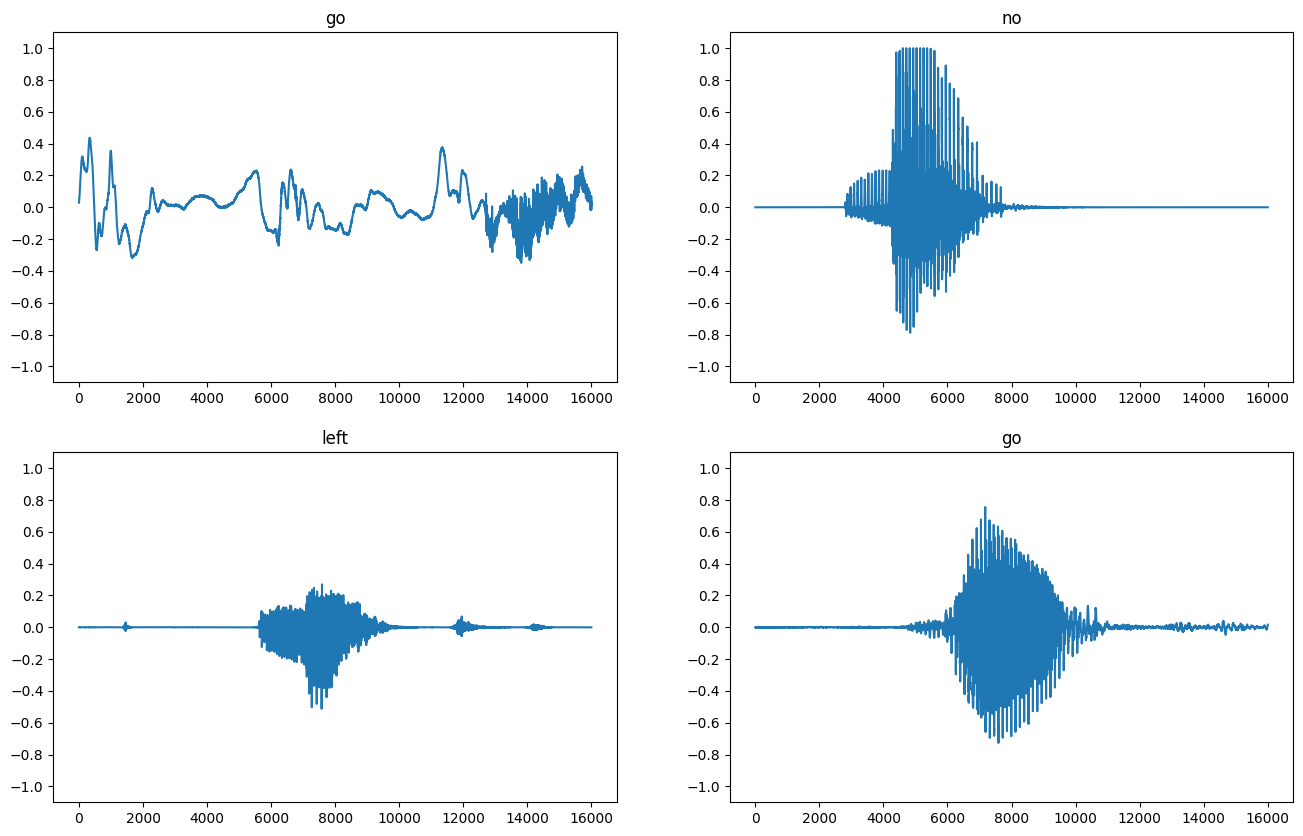

In [22]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [24]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

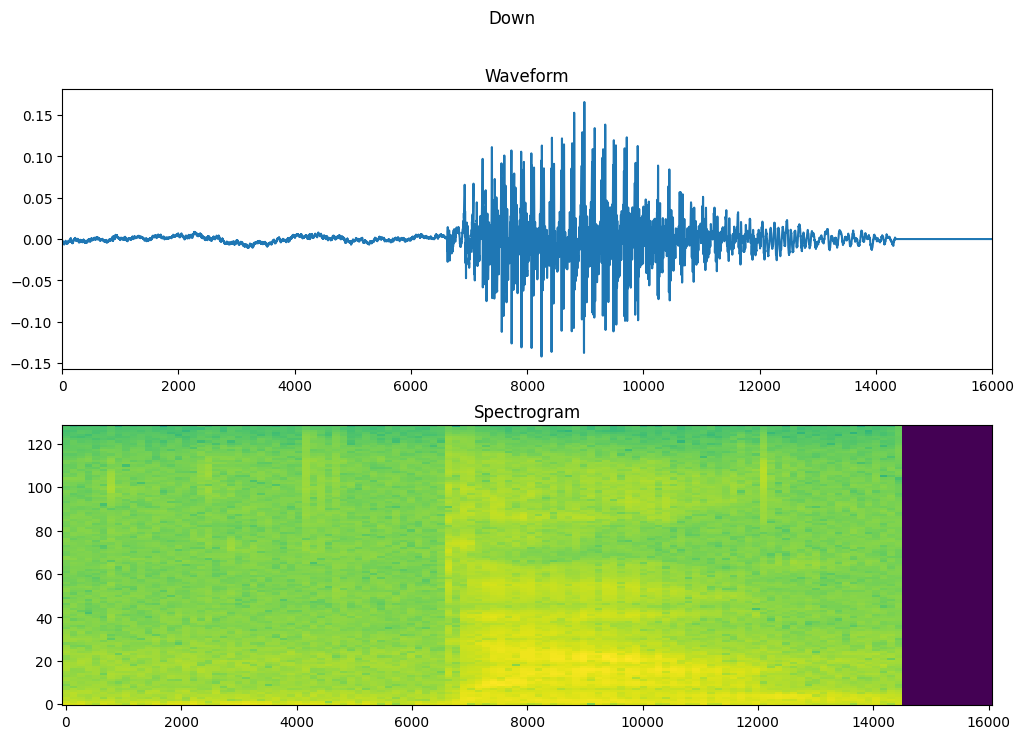

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

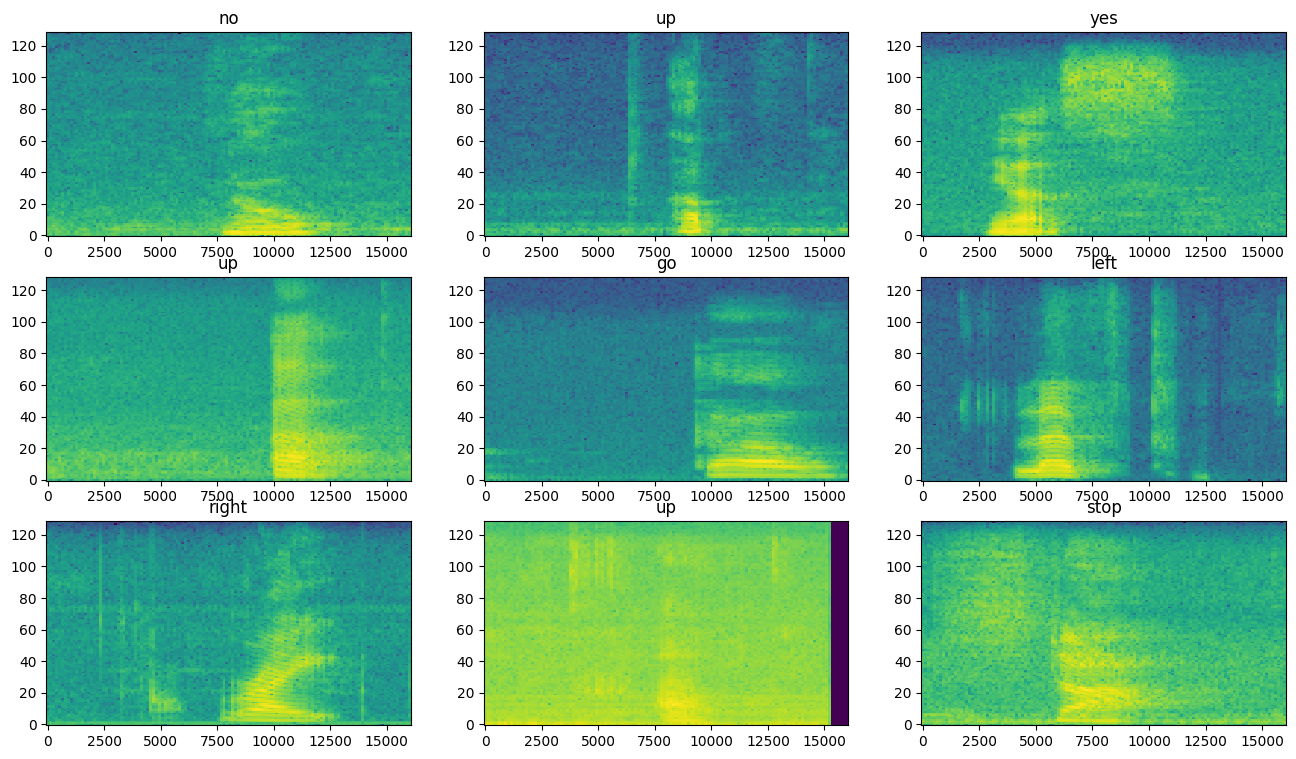

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [32]:
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

In [33]:
rnn_func=L.LSTM

In [34]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
    

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [36]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/20


100/100 [==============================] - 18s 164ms/step - loss: 1.7609 - accuracy: 0.3661 - val_loss: 1.3361 - val_accuracy: 0.5938
Epoch 2/20
100/100 [==============================] - 12s 120ms/step - loss: 1.1778 - accuracy: 0.5922 - val_loss: 0.8986 - val_accuracy: 0.7292
Epoch 3/20
100/100 [==============================] - 12s 117ms/step - loss: 0.8784 - accuracy: 0.6950 - val_loss: 0.7416 - val_accuracy: 0.7734
Epoch 4/20
100/100 [==============================] - 12s 117ms/step - loss: 0.7168 - accuracy: 0.7486 - val_loss: 0.6419 - val_accuracy: 0.8138
Epoch 5/20
100/100 [==============================] - 12s 119ms/step - loss: 0.6029 - accuracy: 0.7850 - val_loss: 0.5796 - val_accuracy: 0.8320
Epoch 6/20
100/100 [==============================] - 11s 115ms/step - loss: 0.5287 - accuracy: 0.8138 - val_loss: 0.5450 - val_accuracy: 0.8073
Epoch 7/20
100/100 [==============================] - 12s 120ms/step - loss: 0.4680 - accuracy: 0.8298 - val_loss: 0.4903 - val_accuracy: 0.8

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

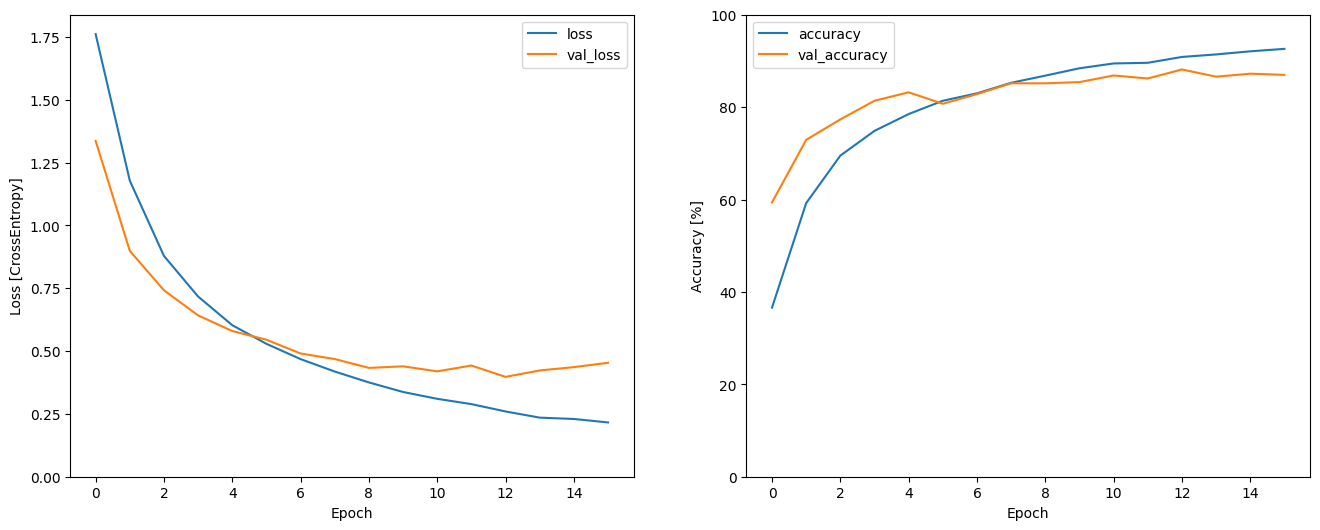

In [45]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [46]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 4/13 [========>.....................] - ETA: 0s - loss: 0.5496 - accuracy: 0.8320

13/13 [==============================] - 0s 26ms/step - loss: 0.4504 - accuracy: 0.8726


{'loss': 0.45040395855903625, 'accuracy': 0.8725961446762085}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [47]:
y_pred = model.predict(test_spectrogram_ds)

 6/13 [============>.................] - ETA: 0s

13/13 [==============================] - 0s 25ms/step


In [48]:
y_pred = tf.argmax(y_pred, axis=1)

In [49]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

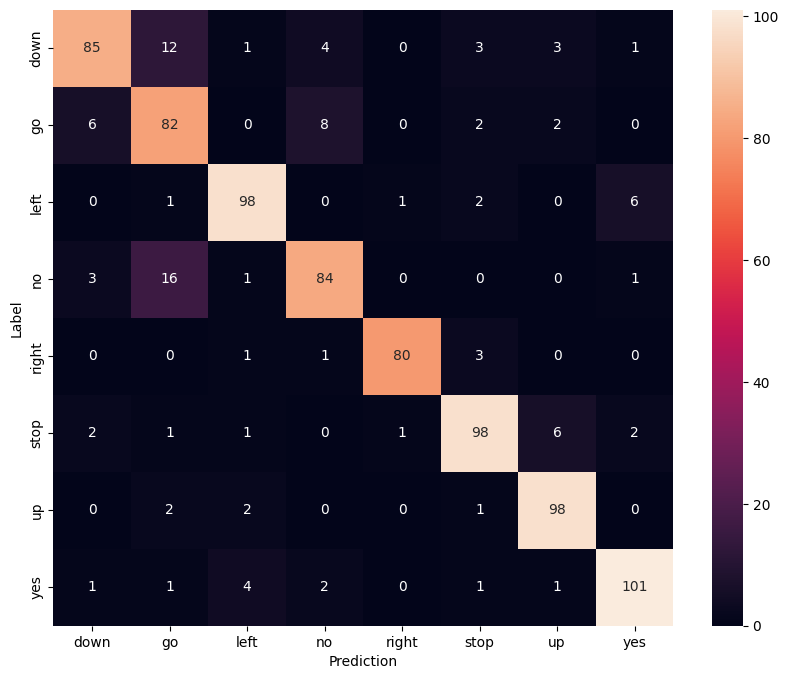

In [50]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [51]:
import sounddevice as sd
import soundfile as sf
import pyautogui

In [44]:
def record_and_process_audio(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=16000, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((audio, padding))
    return audio

def record_and_process_audio_2(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=16000, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((padding, audio))
    return audio

def predict_command(audio):
    audio = audio.astype(np.float32)
    tensor = tf.convert_to_tensor(audio)
    x = tf.squeeze(tensor, axis=-1)

    waveform = x  # Assuming waveform is needed for your processing
    x = get_spectrogram(x)  # Replace with your spectrogram function
    x = x[tf.newaxis, ...]

    prediction = model(x)
    probabilities = tf.nn.softmax(prediction[0])
    predicted_index = tf.argmax(probabilities).numpy()
    # print(probabilities)
    x_labels = ['down', 'down_full', 'jump','left', 'left_full', 'nothing', 'right', 'right_full', 'up']
    return x_labels[predicted_index]

try:
    while True:
        # print("Recording...")
        audio_trigger = record_and_process_audio(0.2, 16000)  # Recording for 0.3 seconds at 16000 Hz sample rate
        predicted_label_trigger = predict_command(audio_trigger)
        # print(f"Predicted command: {predicted_label}")
        if predicted_label_trigger != 'nothing':
            audio_2 = record_and_process_audio_2(1, 16000)
            audio = audio_trigger + audio_2
            predicted_label = predict_command(audio)
            print(predicted_label)
            print("triggered, start recording")
        # Execute the command
            if (predicted_label == 'left') or (predicted_label == 'left_full'):
                # pyautogui.press('left')
                print('left')
            elif (predicted_label == 'right') or (predicted_label == 'right_full'):
                # pyautogui.press('right')
                print('right')
            elif (predicted_label == 'up') or (predicted_label == 'jump'):
                # pyautogui.press('up')
                print('up')
            elif (predicted_label == 'down') or (predicted_label == 'down_full'):
                # pyautogui.press('down')
                print('down')
            else:
                pass
except KeyboardInterrupt:
    print("Stopped by user.")



jump
triggered, start recording
up
right
triggered, start recording
right
down_full
triggered, start recording
down
down
triggered, start recording
down
left
triggered, start recording
left
down_full
triggered, start recording
down
down_full
triggered, start recording
down
Stopped by user.


In [ ]:
def record_and_process_audio(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=16000, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((audio, padding))
    return audio

def record_and_process_audio_2(duration, sample_rate, target_duration=1.0):
    # Record audio
    audio = sd.rec(int(duration * sample_rate), samplerate=16000, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished

    # Calculate the target number of samples
    target_samples = int(target_duration * sample_rate)

    # Pad the audio if it's shorter than the target
    if audio.shape[0] < target_samples:
        padding = np.zeros((target_samples - audio.shape[0], audio.shape[1]))
        audio = np.vstack((audio, padding))
    return audio

def predict_command(audio):
    audio = audio.astype(np.float32)
    tensor = tf.convert_to_tensor(audio)
    x = tf.squeeze(tensor, axis=-1)

    waveform = x  # Assuming waveform is needed for your processing
    x = get_spectrogram(x)  # Replace with your spectrogram function
    x = x[tf.newaxis, ...]

    prediction = model(x)
    probabilities = tf.nn.softmax(prediction[0])
    predicted_index = tf.argmax(probabilities).numpy()
    # print(probabilities)
    x_labels = ['down', 'down_full', 'jump','left', 'left_full', 'nothing', 'right', 'right_full', 'up']
    return x_labels[predicted_index]

try:
    while True:
        # print("Recording...")
        audio = record_and_process_audio_2(0.2, 16000)  # Recording for 0.3 seconds at 16000 Hz sample rate
        predicted_label_trigger = predict_command(audio)
        print(f"Predicted command: {predicted_label}")
        # Execute the command
        if (predicted_label == 'left') or (predicted_label == 'left_full'):
                pyautogui.press('left')
                print('left')
        elif (predicted_label == 'right') or (predicted_label == 'right_full'):
                pyautogui.press('right')
                print('right')
        elif (predicted_label == 'up') or (predicted_label == 'jump'):
                pyautogui.press('up')
                print('up')
        elif (predicted_label == 'down') or (predicted_label == 'down_full'):
                pyautogui.press('down')
                print('down')
        else:
                pass
except KeyboardInterrupt:
    print("Stopped by user.")



Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Predicted command: nothing
Stopped by user.


tf.Tensor(b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\x00}\x00\x00\x05\x00\n\x00\x07\x00\x03\x00\x04\x00\x02\x00\xfe\xff\xfc\xff\xfe\xff\xfb\xff\xfa\xff\xfe\xff\xfa\xff\xf8\xff\xfd\xff\xf7\xff\xf7\xff\x01\x00\x04\x00\x0b\x00\x15\x00\x11\x00\t\x00\x08\x00\x03\x00\xfd\xff\x02\x00\xfe\xff\xf6\xff\xfc\xff\xfc\xff\xf7\xff\xfe\xff\xfe\xff\xfc\xff\x04\x00\x03\x00\xff\xff\x01\x00\x01\x00\x03\x00\x05\x00\x01\x00\x00\x00\x06\x00\x05\x00\xfe\xff\x01\x00\x05\x00\x02\x00\xfd\xff\xfe\xff\x00\x00\xff\xff\xff\xff\x04\x00\x03\x00\x01\x00\x01\x00\xf9\xff\xf4\xff\xfa\xff\xf7\xff\xfa\xff\x07\x00\x02\x00\x00\x00\x05\x00\x01\x00\x07\x00\x06\x00\x05\x00\x0b\x00\x00\x00\x00\x00\x05\x00\xfe\xff\xf9\xff\xf6\xff\xfd\xff\x03\x00\xfb\xff\xfd\xff\xfd\xff\xfb\xff\xff\xff\xfc\xff\xfe\xff\x01\x00\x05\x00\x06\x00\xff\xff\x02\x00\x07\x00\x04\x00\x02\x00\x00\x00\xfe\xff\x03\x00\x05\x00\xff\xff\xfc\xff\x03\x00\x05\x00\xfd\xff\xff\xff\x02\x00\x03\x00\x05\x00\xfb\xf

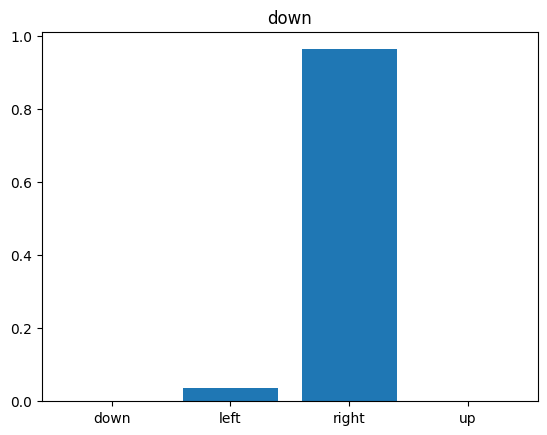

In [ ]:
x = './data/mini_speech_commands/right/11a022ba_nohash_1.wav'
x = tf.io.read_file(x)
print(x)
print(x.shape)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]
prediction = model(x)
x_labels = ['down', 'left', 'right', 'up']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('down')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
import numpy as np
list_1 = np.arange(1,10**6,3)
list_1

array([     1,      4,      7, ..., 999991, 999994, 999997])

In [ ]:
list(set(list_1))

[1,
 4,
 7,
 10,
 13,
 16,
 19,
 22,
 25,
 28,
 31,
 34,
 37,
 40,
 43,
 46,
 49,
 52,
 55,
 58,
 61,
 64,
 67,
 70,
 73,
 76,
 79,
 82,
 85,
 88,
 91,
 94,
 97,
 100,
 103,
 106,
 109,
 112,
 115,
 118,
 121,
 124,
 127,
 130,
 133,
 136,
 139,
 142,
 145,
 148,
 151,
 154,
 157,
 160,
 163,
 166,
 169,
 172,
 175,
 178,
 181,
 184,
 187,
 190,
 193,
 196,
 199,
 202,
 205,
 208,
 211,
 214,
 217,
 220,
 223,
 226,
 229,
 232,
 235,
 238,
 241,
 244,
 247,
 250,
 253,
 256,
 259,
 262,
 265,
 268,
 271,
 274,
 277,
 280,
 283,
 286,
 289,
 292,
 295,
 298,
 301,
 304,
 307,
 310,
 313,
 316,
 319,
 322,
 325,
 328,
 331,
 334,
 337,
 340,
 343,
 346,
 349,
 352,
 355,
 358,
 361,
 364,
 367,
 370,
 373,
 376,
 379,
 382,
 385,
 388,
 391,
 394,
 397,
 400,
 403,
 406,
 409,
 412,
 415,
 418,
 421,
 424,
 427,
 430,
 433,
 436,
 439,
 442,
 445,
 448,
 451,
 454,
 457,
 460,
 463,
 466,
 469,
 472,
 475,
 478,
 481,
 484,
 487,
 490,
 493,
 496,
 499,
 502,
 505,
 508,
 511,
 514,
 517

In [ ]:
list_2 = np.arange(1,10**6,7)
list_2

array([     1,      8,     15, ..., 999979, 999986, 999993])

In [ ]:
list_3 = np.concatenate((list_1, list_2))


In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'left/00b01445_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 1.2582613, 11.812878 , -5.5495043, -1.4444207]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'left'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'down'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 1.7262106,  1.1506386, -2.0522597, -0.4897965]], dtype=float32)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.

In [ ]:
file_to_down = [file for file in os.listdir('/content/saved')]
file_to_down

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/saved'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/saved

/content/saved


In [ ]:
!zip -r saved_model.zip . -i content/saved/

	zip warning: zip file empty


In [ ]:
!zip -r /content/saved.zip /content/saved/

  adding: content/saved/ (stored 0%)
  adding: content/saved/saved_model.zip (stored 0%)
  adding: content/saved/fingerprint.pb (stored 0%)
  adding: content/saved/variables/ (stored 0%)
  adding: content/saved/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved/variables/variables.index (deflated 62%)
  adding: content/saved/assets/ (stored 0%)
  adding: content/saved/saved_model.pb (deflated 86%)


In [ ]:
files.download('/content/saved.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Specify the path of the file you want to download
file_path = "saved"  # Update this with the actual file path

# Trigger the download
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

file_path = "/content/saved"
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>